# **SOPORTE: Proceso esquematizado para la realización del reto (Objetivo_1)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U pymgrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-1.2.2-py3-none-any.whl size=3492850 sha256=5dbf2ecc2b13b2cd2c3b3f3ac7c39bb6ba2ba413a35dc35878ee2a859284989c
  Stored in directory: /root/.cache/pip/wheels/aa/9c/34/d880763dcc693c67448303756a6e1adb899bdc0d5080643030
Successfully built pymgrid


In [3]:
!pip install git+https://github.com/Wenuka/pymgrid/


  Cloning https://github.com/Wenuka/pymgrid/ to /tmp/pip-req-build-hd08c0_p
  Running command git clone --filter=blob:none --quiet https://github.com/Wenuka/pymgrid/ /tmp/pip-req-build-hd08c0_p
  Resolved https://github.com/Wenuka/pymgrid/ to commit 6a8091e1ee554c65bdb4bb229570aa94a3bf4a03
  Preparing metadata (setup.py) ... done
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3424052 sha256=c1b87abbd9016747c0ed2f99cbab36e5d829324b5090926d253f4f7a43049b41
  Stored in directory: /tmp/pip-ephem-wheel-cache-pss6i5e7/wheels/cd/b4/15/71aa9cbda578c3c22dfcbc0fb165c27772f2099892ca060bd1
Successfully built pymgrid
  Attempting uninstall: pymgrid
    Found existing installation: pymgrid 1.2.2
    Uninstalling pymgrid-1.2.2:
      Successfully uninstalled pymgrid-1.2.2


In [4]:
import gymnasium as gym

In [5]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import matplotlib.pyplot as plt

!python --version

Python 3.11.11


Nota: Proceso para importar carpeta "data2" en colab

In [6]:
# Selección de archivo (.zip) en Colab a partir de un cuadro de dialogo
from google.colab import files

archivo_subido = files.upload()


Saving data.zip to data.zip


In [7]:
# Unzip del fichero seleccionado
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [8]:
env = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")  # we use a custom file to simulate the load and the PV
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]
mg0.architecture

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

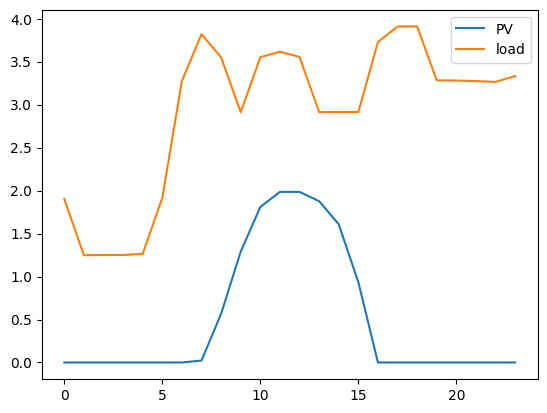

In [9]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()

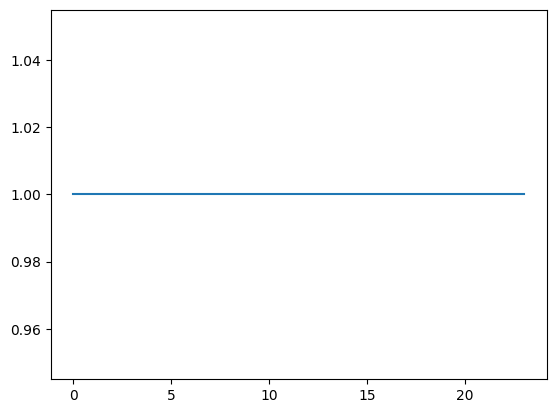

In [10]:
plt.plot(mg0.forecast_grid_status())

**Lo estados podrían ser:**
- Carga (kW)
- FV (kW)
- Bateria (% carga)
- Conexión a red (constante siempre a 1)

Finalmente, podemos definir la carga de red como: carga - FV, así que realmente tenemos **"dos estados"**:

**(Net_load, battery %)**

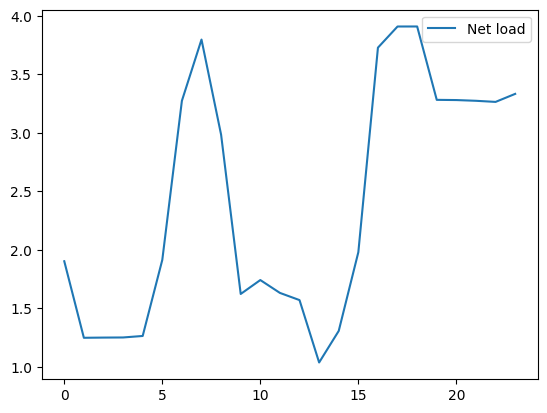

In [11]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

Discretizamos el environment

Current load: 1.9025237435023625
Current PV: 0.0
Battery capacity: 16
Battery state of charge: 0.2


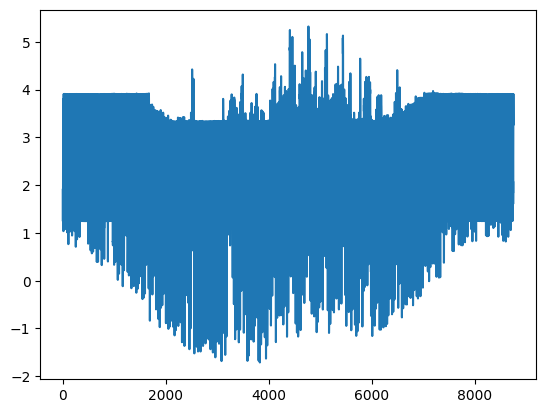

In [12]:
mg0.set_horizon(24*365) # Intervalo de tiempo sobre el cual extraer datos
overall_net_load = mg0.forecast_load()-mg0.forecast_pv()
overal_min = min(overall_net_load)
overal_max = max(overall_net_load)
discretize_interval = 1
net_load_params = (overal_min, overal_max, discretize_interval) # Variable para llamar a función
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")

current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity
battery_state_of_charge = mg0.battery.soc

print(f"Current load: {current_load}")
print(f"Current PV: {current_pv}")
print(f"Battery capacity: {battery_capacity}")
print(f"Battery state of charge: {battery_state_of_charge}")

**Discretizar:** Para aplicarQ-learning definimos estados discretos

**Acciones:**
- Action 0: cargar batería
- Action 1: descargar batería
- Action 2: comprar de la red
- Action 3: vender a la red

**Definimos las acciones, de acuerdo a lo indicado:**

Nota: "La manera o forma de aplicar estas acciones, será explicada en el reto para que no les de a duda de como calcular cada una de ellas.

In [13]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv

    # Calculamos parámetros de la bateria ###
    # Parámetros para la carga:
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # Valor de carga para el periodo de tiempo definido (time stamp) charge value for the time
    # Parámetros para la descarga
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time

    if action == 0:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': p_charge,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':max(0,pv - min(pv,load) - p_charge)
                       }
    elif action ==1:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'grid_import': max(0,load - min(pv,load) - p_discharge),
                        'grid_export':0
                       }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }

    return control_dict

**Inicializamos la Q-table:**

In [14]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [15]:
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
from gymnasium import spaces
import numpy as np
class MicrogridEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, microgrid, horizon=24*7):
        super().__init__()
        self.microgrid = microgrid
        self.horizon = horizon
        self.current_step = 0

        forecast_load = self.microgrid.forecast_load()
        forecast_pv = self.microgrid.forecast_pv()
        net_load = forecast_load - forecast_pv

        self.observation_space = spaces.Box(
            low=np.array([net_load.min(), 0.0], dtype=np.float32),
            high=np.array([net_load.max(), 1.0], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

    def reset(self, seed=None, options=None):
        self.microgrid.reset()
        self.current_step = 0
        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        return np.array([net_load, soc], dtype=np.float32), {}

    def step(self, action):
        control_dict = actions_agent(self.microgrid, action)
        self.microgrid.run(control_dict)

        cost = self.microgrid.get_cost()
        reward = -cost

        self.current_step += 1
        done = self.current_step >= self.horizon

        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        observation = np.array([net_load, soc], dtype=np.float32)

        return observation, reward, done, False, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Load: {self.microgrid.load - self.microgrid.pv}, Battery SOC: {self.microgrid.battery.soc}")

    def close(self):
        pass

In [16]:
from stable_baselines3.common.env_checker import check_env

mg0 = env.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env)

check_env(env)

# PPO

In [17]:
from stable_baselines3 import PPO
import os

env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

os.makedirs("./logs/", exist_ok=True)
env_ppo = MicrogridEnv(mg0)
env_ppo = Monitor(env_ppo, filename="./logs/monitor_ppo.csv")
check_env(env_ppo)


os.rename("./logs/monitor_ppo.csv.monitor.csv", "./logs/monitor_ppo.csv")

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

In [18]:
import pandas as pd
model = PPO("MlpPolicy", env_ppo, verbose=1)
model.learn(total_timesteps=100000)
model.save("ppo_microgrid")
env_ppo.close()

log_df = pd.read_csv("./logs/monitor_ppo.csv", skiprows=1)

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 168       |
|    ep_rew_mean     | -3.09e+03 |
| time/              |           |
|    fps             | 549       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 168         |
|    ep_rew_mean          | -2.84e+03   |
| time/                   |             |
|    fps                  | 505         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015178625 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    expla

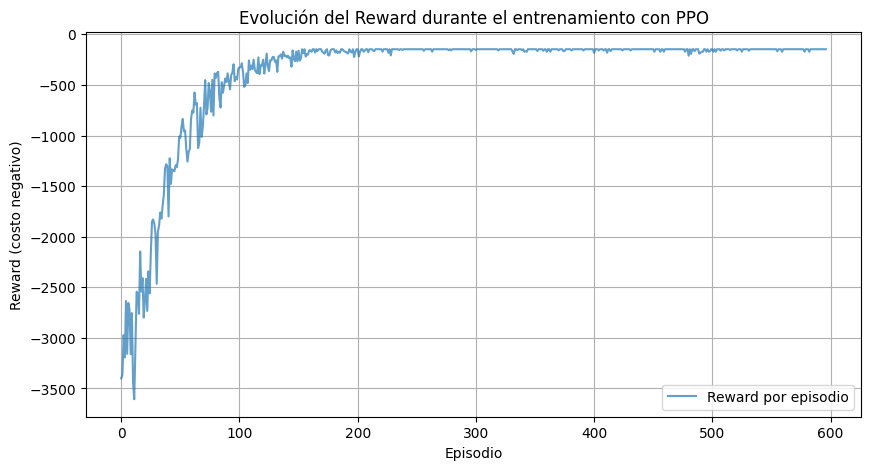

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento con PPO")
plt.legend()
plt.grid()
plt.show()

In [20]:
env = MicrogridEnv(mg0)
env = Monitor(env, filename="./logs/monitor_eval.csv")

obs, _ = env.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
print("Recompensa total del episodio evaluado con PPO:", total_reward)

env.close()

Recompensa total del episodio evaluado con PPO: -146.77412390930058


# PPO - OPTUNA

In [21]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.8 MB/s eta 0:00:00


In [22]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
import os
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def make_env():
    env = MicrogridEnv(mg0)
    env = Monitor(env, filename="./logs/monitor_optuna.csv")
    return env

def objective(trial):
    """Función objetivo para la optimización con Optuna."""

    # Definir el espacio de búsqueda de hiperparámetros
    gamma = trial.suggest_float("gamma", 0.8, 0.9999)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    n_steps = trial.suggest_int("n_steps", 128, 4096, step=128)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512])
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.1)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.5)

    env = make_env()

    model = PPO(
        "MlpPolicy",
        env,
        gamma=gamma,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        ent_coef=ent_coef,
        clip_range=clip_range,
        verbose=0
    )

    model.learn(total_timesteps=50_000)  # Puedes ajustar este número para acelerar la optimización

    # Evaluar el modelo en un episodio
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    env.close()

    return total_reward  # Maximizar la recompensa

In [24]:
# Generar el entorno de la microgrid
env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")
env_gen.generate_microgrid(verbose=False)
mg0 = env_gen.microgrids[0]

# Ejecutar la optimización de hiperparámetros con Optuna
study = optuna.create_study(direction="maximize",  storage="sqlite:///microgrid_ppo_v1.db", study_name='microgrid_ppo_v1', load_if_exists=True)
study.optimize(objective, n_trials=20)  # Puedes aumentar el número de pruebas

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:", study.best_params)


/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.11/dist-packages/pymgrid/MicrogridGenerator.py:340: DeprecationWarning:

Conversion

Mejores hiperparámetros encontrados: {'gamma': 0.8970828672411705, 'learning_rate': 0.0004167240894748237, 'n_steps': 2048, 'batch_size': 256, 'ent_coef': 0.0720426492008112, 'clip_range': 0.27341453240277014}


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 168       |
|    ep_rew_mean     | -3.26e+03 |
| time/              |           |
|    fps             | 403       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 2048      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 168        |
|    ep_rew_mean          | -2.81e+03  |
| time/                   |            |
|    fps                  | 229        |
|    iterations           | 2          |
|    time_elapsed         | 17         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03967584 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.273      |
|    entropy_loss         | -1.36      |
|    explained_variance 

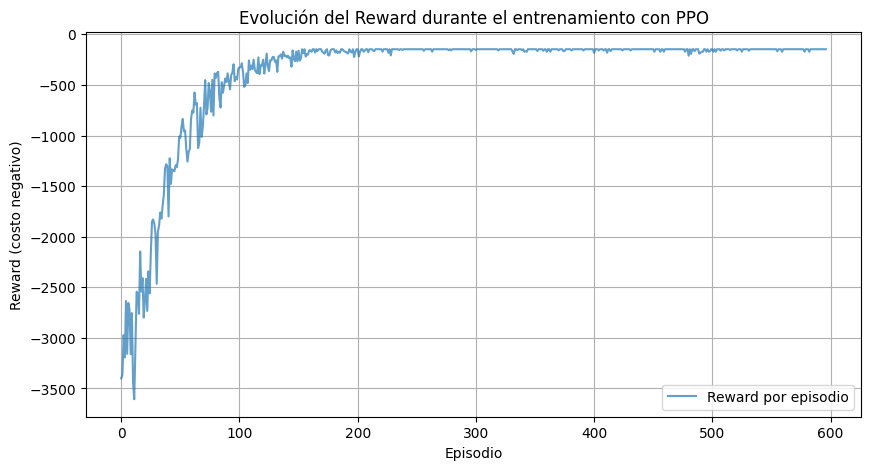

Recompensa total del episodio evaluado con PPO: -146.77412390930058


In [25]:
# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
env_ppo = make_env()

model = PPO(
    "MlpPolicy",
    env_ppo,
    gamma=best_params["gamma"],
    learning_rate=best_params["learning_rate"],
    n_steps=best_params["n_steps"],
    batch_size=best_params["batch_size"],
    ent_coef=best_params["ent_coef"],
    clip_range=best_params["clip_range"],
    verbose=1
)

model.learn(total_timesteps=100_000)
model.save("ppo_microgrid_best")
env_ppo.close()

# Graficar evolución del reward
log_df = pd.read_csv("./logs/monitor_ppo.csv", skiprows=1)

plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento con PPO")
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo entrenado
env_eval = MicrogridEnv(mg0)
env_eval = Monitor(env_eval, filename="./logs/monitor_eval.csv")

obs, _ = env_eval.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env_eval.step(action)
    total_reward += reward

print("Recompensa total del episodio evaluado con PPO:", total_reward)

env_eval.close()

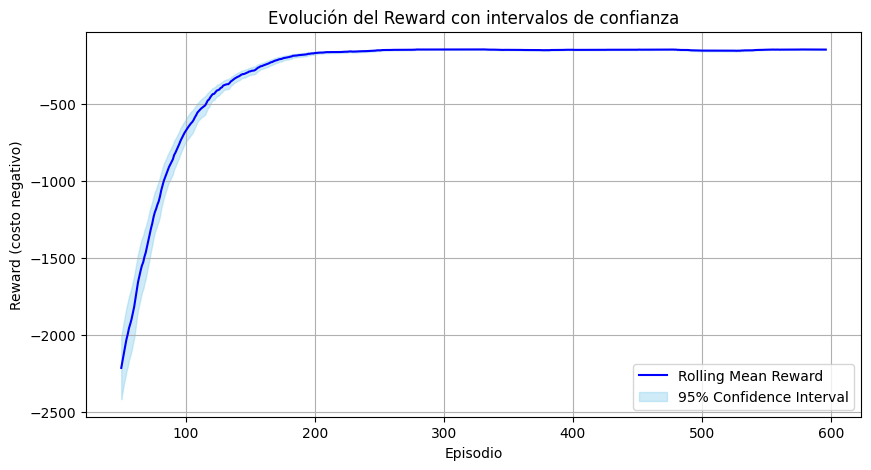

In [32]:
import scipy
def compute_confidence_intervals(data, confidence=0.95):
    """Compute confidence intervals for a given dataset."""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Calculate rolling mean and confidence intervals
rolling_window = 50 # Adjust window size as needed

# Assuming log_df has a column named 'r' for rewards
rewards = log_df['r']
rolling_mean = rewards.rolling(window=rolling_window).mean()

# Calculate confidence intervals for each rolling mean window
confidence_intervals = []
for i in range(rolling_window, len(rewards)):
  window = rewards[i - rolling_window : i]
  m, lower, upper = compute_confidence_intervals(window)
  confidence_intervals.append((m, lower, upper))

# Extract values for plotting
rolling_means = [m for m, _, _ in confidence_intervals]
lower_bounds = [lower for _, lower, _ in confidence_intervals]
upper_bounds = [upper for _, _, upper in confidence_intervals]
x_values = range(rolling_window, len(rewards))

# Plotting the reward with confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(x_values, rolling_means, label='Rolling Mean Reward', color="blue")
plt.fill_between(x_values, lower_bounds, upper_bounds, color='skyblue', alpha=0.4, label='95% Confidence Interval')
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward con intervalos de confianza")
plt.legend()
plt.grid()
plt.show()


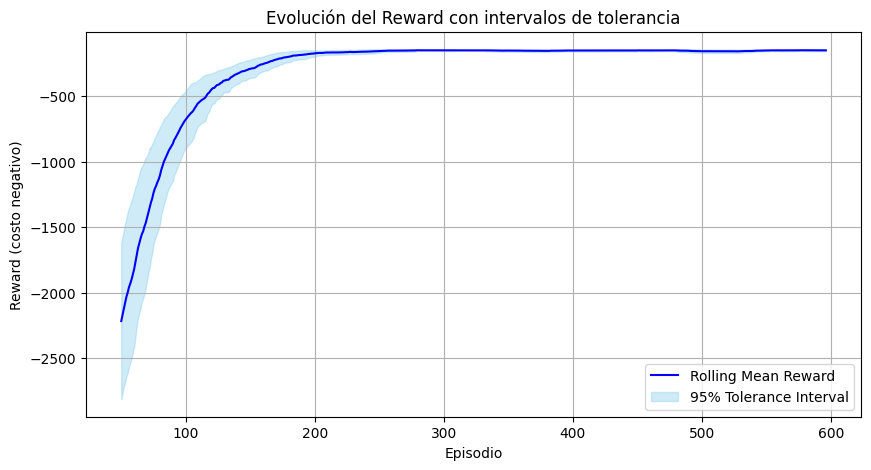

In [34]:
def compute_tolerance_intervals(data, tolerance=0.95):
    """Compute tolerance intervals for a given dataset."""
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    s = np.std(a, ddof=1)  # Use sample standard deviation
    k = np.sqrt( (n - 1) / scipy.stats.chi2.ppf((1 + tolerance)/2, n - 1))
    return m, m - k * s, m + k*s


rolling_window = 50

rewards = log_df['r']
rolling_mean = rewards.rolling(window=rolling_window).mean()

tolerance_intervals = []
for i in range(rolling_window, len(rewards)):
    window = rewards[i - rolling_window:i]
    m, lower, upper = compute_tolerance_intervals(window)
    tolerance_intervals.append((m, lower, upper))

rolling_means = [m for m, _, _ in tolerance_intervals]
lower_bounds = [lower for _, lower, _ in tolerance_intervals]
upper_bounds = [upper for _, _, upper in tolerance_intervals]
x_values = range(rolling_window, len(rewards))

plt.figure(figsize=(10, 5))
plt.plot(x_values, rolling_means, label='Rolling Mean Reward', color="blue")
plt.fill_between(x_values, lower_bounds, upper_bounds, color='skyblue', alpha=0.4, label='95% Tolerance Interval')
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward con intervalos de tolerancia")
plt.legend()
plt.grid()
plt.show()


In [26]:
archivo_subido = files.upload()

with zipfile.ZipFile("data4.zip", 'r') as zip_ref:
    zip_ref.extractall("./")  # Extraer en el directorio correcto

env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data4/pymgrid_data")

Saving data4.zip to data4.zip


In [27]:
archivo_subido = files.upload()

with zipfile.ZipFile("data_pv_low_load_high.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_pv_low_load_high")

env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")

Saving data_pv_low_load_high.zip to data_pv_low_load_high.zip


In [28]:
import pytest
import copy
import numpy as np
import random
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


env_gen = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")
env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data4/pymgrid_data")
env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")


def simulate_env(model, microgrid, num_episodes=50):
    """
    Ejecuta num_episodes en el entorno y retorna el reward promedio.
    """
    set_seed(42)

    simulation_env = MicrogridEnv(microgrid)
    simulation_env = Monitor(simulation_env)
    rewards = []

    for episode in range(num_episodes):
        obs, _ = simulation_env.reset(seed=42)
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = simulation_env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)

    return np.mean(rewards)

@pytest.fixture
def trained_model_and_microgrid():
    """Fixture para cargar modelo y microgrid."""
    set_seed(42)
    env_gen.generate_microgrid(verbose=False)
    mg0 = copy.deepcopy(env_gen.microgrids[0])
    model = PPO.load("ppo_microgrid_best")
    return model, mg0

def test_increased_load(trained_model_and_microgrid):
    model, mg0 = trained_model_and_microgrid
    set_seed(42)

    avg_reward_orig = simulate_env(model, mg0, num_episodes=50)

    env_test2.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test2.microgrids[0])

    avg_reward_mod = simulate_env(model, mg_mod, num_episodes=50)

    assert avg_reward_mod < avg_reward_orig, (
        f"Error: Carga aumentada -> Reward esperado: {avg_reward_orig} vs Actual: {avg_reward_mod}"
    )

    print(f"Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")


def test_increased_pv(trained_model_and_microgrid):
    model, mg0 = trained_model_and_microgrid
    set_seed(42)

    avg_reward_orig = simulate_env(model, mg0, num_episodes=50)

    env_test1.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test1.microgrids[0])

    avg_reward_mod = simulate_env(model, mg_mod, num_episodes=50)

    assert avg_reward_mod > avg_reward_orig, (
        f"Error: PV aumentada -> Reward esperado: {avg_reward_orig} vs Actual: {avg_reward_mod}"
    )

    print(f"Test 'increased pv' passed: al aumentar la generación PV, el coste global es menor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")


In [29]:
!pip install ipytest

In [30]:
import ipytest
ipytest.autoconfig()
ipytest.run("--maxfail=2", "--disable-warnings", "-s")

Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: -146.77412390930056. Coste medio modificado: -291.93767141560636
.F
============================================= FAILURES =============================================
________________________________________ test_increased_pv _________________________________________

trained_model_and_microgrid = (<stable_baselines3.ppo.ppo.PPO object at 0x7cffb7632550>, <pymgrid.Microgrid.Microgrid object at 0x7cffb7634850>)

    def test_increased_pv(trained_model_and_microgrid):
        model, mg0 = trained_model_and_microgrid
        set_seed(42)
    
        avg_reward_orig = simulate_env(model, mg0, num_episodes=50)
    
        env_test1.generate_microgrid(verbose=False)
        mg_mod = copy.deepcopy(env_test1.microgrids[0])
    
        avg_reward_mod = simulate_env(model, mg_mod, num_episodes=50)
    
>       assert avg_reward_mod > avg_reward_orig, (
            f"Error: PV aumentada -> Rew

<ExitCode.TESTS_FAILED: 1>